# Отток клиентов банка

## Введение

**Цель проекта**: построение модели для задачи классификации: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, исходя из предоставленных исторических данных о поведении клиентов и расторжении договоров с банком.


**Входные данные** 

Информация об исторических данных о поведении клиентов и расторжении договоров с банком (*/datasets/Churn.csv*):  


***Признаки***
- *RowNumber* — индекс строки в данных
- *CustomerId* — уникальный идентификатор клиента
- *Surname* — фамилия
- *CreditScore* — кредитный рейтинг
- *Geography* — страна проживания
- *Gender* — пол
- *Age* — возраст
- *Tenure* — количество недвижимости у клиента
- *Balance* — баланс на счёте
- *NumOfProducts* — количество продуктов банка, используемых клиентом
- *HasCrCard* — наличие кредитной карты
- *IsActiveMember* — активность клиента
- *EstimatedSalary* — предполагаемая зарплата  


***Целевой признак***
- *Exited* — факт ухода клиента

## Подготовка и общий обзор полученных данных

Импортируем необходимые библиотеки для дальнейшей работы:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle

Прочтем предоставленный файл и сохраним DataFrame в соответствующей переменной. Выведем и изучим общую информацию о полученных данных, проверим корректность названий столбцов, количество пропусков и дубликатов:

In [2]:
clients_data = pd.read_csv('/datasets/Churn.csv')

clients_data.info()
print()
print(clients_data.columns)
print()
display(clients_data.head())
print()
print('Количество пропусков:')
print(clients_data.isna().sum())
print()
print('Количество дубликатов:', clients_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Количество пропусков:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Количество дубликатов: 0


Приведем наименования столбцов к удобному для работы формату: 

In [3]:
clients_data.set_axis(['row_number', 'custumer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 
                      'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 
                      'exited'], axis='columns', inplace=True)
print(clients_data.columns)

Index(['row_number', 'custumer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


Заполним пропуски в столбце 'tenure': скорее всего NaN означает отсутствие у клиента недвижимости, вполне вероятно что он просто оставил данное поле незаполненным. Удаление строк с пропусками нецелесообразно, поскольку мы теряем почти 9.1% данных:

In [4]:
clients_data['tenure'] = clients_data['tenure'].fillna(0)
clients_data['tenure'].value_counts()

0.0     1291
1.0      952
2.0      950
8.0      933
3.0      928
5.0      927
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
Name: tenure, dtype: int64

Для проверки признаков на наличие мультиколлинеарности построим матрицу корреляции. 

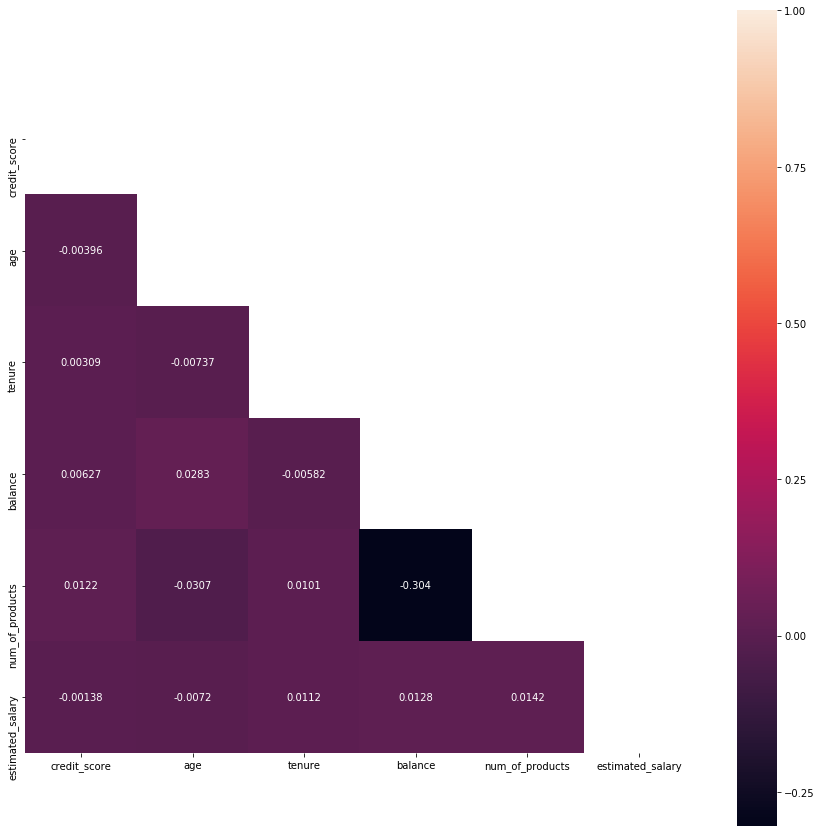

In [5]:
# Исключим столбцы с качественными переменными
clients_data_matrix = clients_data.drop(['row_number','custumer_id', 'has_cr_card', 'is_active_member', 'exited'], axis=1)

matrix = np.triu(clients_data_matrix.corr())
plt.figure(figsize=(15,15))
sns.heatmap(clients_data_matrix.corr(), annot=True, mask=matrix, fmt='.3g', square=True)

Мы видим, что корреляционная связь между показателями крайне слаба - самый большой коэффициент не превышает значения 0.03. Из этого можно сделать вывод о том, что мультиколлинеарность между показателями отсутствует.

Подготовим данные для дальнейшей работы:
- 'row_number': данные практически дублируют индексы df и не несут смысловой нагрузки для поставленных целей - убираем за ненужностью.
- 'custumer_id', 'surname': идентификатор пользователя и его фамилия нам также не помогут в решении вопроса - убираем.
Прочие признаки нужны для построения модели, мультиколлинеарность между признаками не выявлена.

Преобразуем категориальные признаки 'geography', 'gender' в численные. воспользуемся техникой OHE (т.к. она применима ко всем моделям) и избавимся от dummy-ловушки.

In [6]:
# Уберем ненужные столбцы:
clients_data = clients_data.drop(['row_number', 'custumer_id', 'surname'], axis=1)
clients_data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
# Кодирование OHE:
clients_data_ohe = pd.get_dummies(clients_data, drop_first=True)
display(clients_data_ohe.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Из-за разного масштаба признаков требуется провести их стандартизацию. 
Для начала выделим обучающую, валидационную и тестовую выборки, используя метод train_test_split, и сохраним их в соответствующих переменных. Поскольку у нас нет спрятанной тестовой выборки, используем для разделения соотношение 60/20/20:

In [8]:
clients_data_train, clients_data_other = train_test_split(clients_data_ohe, test_size=0.4, random_state=42)
clients_data_valid, clients_data_test = train_test_split(clients_data_other, test_size=0.5, random_state=42)
print(clients_data_train.shape, clients_data_valid.shape, clients_data_test.shape)

(6000, 12) (2000, 12) (2000, 12)


Для каждой выборки выделим набор переменных и целевые признаки:

In [9]:
features_train = clients_data_train.drop('exited', axis=1)
target_train = clients_data_train['exited']
features_valid = clients_data_valid.drop('exited', axis=1)
target_valid = clients_data_valid['exited']
features_test = clients_data_test.drop('exited', axis=1)
target_test = clients_data_test['exited'].reset_index(drop=True)

Проведем стандартизацию признаков:

In [10]:
numeric_columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])


features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

**Вывод:**

Мы подготовили данные для обучения модели: провели кодирование, масштабирование, разделение выборок.

## Исследование моделей

Исследуем адекватность модели. Для проведения соответствующей оценки проверим, как часто в целевом признаке встречается класс «1» или «0» методом 'value_counts()':

In [11]:
class_frequrncy = clients_data_ohe['exited'].value_counts(normalize=True)
print('Частоты классов целевого признака по датасету:')
print(class_frequrncy)

Частоты классов целевого признака по датасету:
0    0.7963
1    0.2037
Name: exited, dtype: float64


На каждый положительный ответ приходится примерно 4 отрицательных. Судя по всему, мы столкнулись с дисбалансом классов.

Обучим модели Дерева решений, Случайного леса и Логистической регрессии, и получим результаты предсказания на валидационной и тестовой выборках. 
После этого проанализируем частоты классов в результатах предсказаний по каждой из моделей и просчитаем метрики качества (accuracy, recall, precosion, f1, AUC-ROC):

### *дерево решений*

In [12]:
# Уберем предупреждения, которые могут выйти в дальнейшем:
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore")


# Создадим фукнкцию для дерева решений:
def decision_tree_model(r_state, depth, cl_weight, features, target):
    model = DecisionTreeClassifier(random_state=r_state, max_depth = depth, class_weight=cl_weight)
    model.fit(features, target)
    return model

In [13]:
# Определим наилучшие гиперпараметры для модели:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 11):
#for depth in range(1,101): # на глубине в 100 результат не меняется - лучший результат при значении,  равном 6
    model = decision_tree_model(42, depth, None, features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_depth = depth
        best_model = model
        best_result = result

print('Лучшая модель:')
print(best_model)
print('Лучшее значение f1 выборки: {:.6f}'.format(best_result))

Лучшая модель:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Лучшее значение f1 выборки: 0.527687


Построим модель с найденными оптимальными параметрами и предскажем результаты на тестовой выборке. Выведем метрики качества для полученной модели на валидационной и тестовой выборках:

In [14]:
# Создадим функцию для предсказаний и вывода метрик:
def metrics_score(name, features, target):
    predictions = model.predict(features)
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    class_frequency = pd.Series(predictions).value_counts(normalize=True)
    print(name)
    print('Частоты классов в предсказаниях')
    print(class_frequency)
    print('Матрица ошибок')
    print(confusion_matrix(target, predictions))
    print('Accuracy: {:.6f}'.format(accuracy_score(target, predictions)))
    print('Recall: {:.6f}'.format(recall_score(target, predictions)))
    print('Precision: {:.6f}'.format(precision_score(target, predictions)))
    print('F1: {:.6f}'.format(f1_score(target, predictions)))
    print('AUC-ROC: {:.6f}'.format(roc_auc_score(target, probabilities_one)))
    print()
    return pd.Series([name, 
                      accuracy_score(target, predictions), 
                      recall_score(target, predictions),
                      precision_score(target, predictions),
                      f1_score(target, predictions),
                      roc_auc_score(target, probabilities_one)])

In [15]:
model = decision_tree_model(42, 6, None, features_train, target_train)
# Сохраним метрики в переменной: dt - decision_tree, n0 - normal_selection, class_weight=None
dt_n0_valid = metrics_score('valid', features_valid, target_valid) 
dt_n0_test = metrics_score('test', features_test, target_test)

valid
Частоты классов в предсказаниях
0    0.883
1    0.117
dtype: float64
Матрица ошибок
[[1548   72]
 [ 218  162]]
Accuracy: 0.855000
Recall: 0.426316
Precision: 0.692308
F1: 0.527687
AUC-ROC: 0.807398

test
Частоты классов в предсказаниях
0    0.864
1    0.136
dtype: float64
Матрица ошибок
[[1504   66]
 [ 224  206]]
Accuracy: 0.855000
Recall: 0.479070
Precision: 0.757353
F1: 0.586895
AUC-ROC: 0.840934



Снова видим дисбаланс классов, причем соотношение сдвинулось в сторону увеличения числа отрицательных ответов.  
Полученное значение показателя F1 валидационной выборки не удовлетворяет требуемому граничному значению 0.59.

### *случайный лес*

In [16]:
# Создадим фукнкцию для случайного леса:
def random_forest_model(r_state, depth, est, cl_weight, features, target):
    model = RandomForestClassifier(random_state=r_state, max_depth = depth, n_estimators = est, class_weight=cl_weight)
    model.fit(features, target)
    return model

In [17]:
# Случайный лес
best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in tqdm(range(1,101)): 
    for depth in range(1,21):
        model = random_forest_model(42, depth, est, None, features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

print('Лучшая модель:')
print(best_model)
print('Лучшее значение f1 валидационной выборки: {:.6f}'.format(best_result))

100%|██████████| 100/100 [13:43<00:00,  8.23s/it]

Лучшая модель:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=78,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Лучшее значение f1 валидационной выборки: 0.576728


Построим модель с найденными оптимальными параметрами и предскажем результаты на тестовой выборке:

In [18]:
model = random_forest_model(42, 12, 78, None, features_train, target_train)
rf_n0_valid = metrics_score('valid', features_valid, target_valid) 
rf_n0_test = metrics_score('test', features_test, target_test)

valid
Частоты классов в предсказаниях
0    0.8935
1    0.1065
dtype: float64
Матрица ошибок
[[1578   42]
 [ 209  171]]
Accuracy: 0.874500
Recall: 0.450000
Precision: 0.802817
F1: 0.576728
AUC-ROC: 0.839198

test
Частоты классов в предсказаниях
0    0.875
1    0.125
dtype: float64
Матрица ошибок
[[1522   48]
 [ 228  202]]
Accuracy: 0.862000
Recall: 0.469767
Precision: 0.808000
F1: 0.594118
AUC-ROC: 0.862808



Тот же дисбаланс классов.

Модель дала гораздо лучшие предсказания, чем предыдущая. Метрики F1 для тестовой выборки превышают требуемое значение 0.59. Посмотрим позднее, что случится, когда мы избавимся от дисбаланса.

### *логистическая регрессия*

In [19]:
# Логистическая регрессия
model = LogisticRegression(random_state=42)
model.fit(features_train, target_train)

lr_n0_valid = metrics_score('valid', features_valid, target_valid) 
lr_n0_test = metrics_score('test', features_test, target_test)

valid
Частоты классов в предсказаниях
0    0.9305
1    0.0695
dtype: float64
Матрица ошибок
[[1558   62]
 [ 303   77]]
Accuracy: 0.817500
Recall: 0.202632
Precision: 0.553957
F1: 0.296724
AUC-ROC: 0.753265

test
Частоты классов в предсказаниях
0    0.9195
1    0.0805
dtype: float64
Матрица ошибок
[[1503   67]
 [ 336   94]]
Accuracy: 0.798500
Recall: 0.218605
Precision: 0.583851
F1: 0.318105
AUC-ROC: 0.778840



Метрики модели логистической регрессии показывают наихудшие результаты.

**Вывод:**   

Целевой признак содержит дисбаланс классов, от которого следует избавиться. Мы видим, что наилучшие результаты показывает модель случайного леса.

# 3. Борьба с дисбалансом и тестирование моделей

Мы выявили, что в наших моделях присутствует дисбаланс классов. Для того, чтобы избавиться от него попробуем воспользоваться увеличением выборки, уменьшением выборки, а также установим для моделей гиперпараметр `class_weight='balanced'`.

In [20]:
# Составим функцию для увеличения выборки:
def upsample(features, target, repeat):
    # Разделим обучающую выборку на отрицательные и положительные объекты:
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # Перемешаем данные
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled

In [21]:
# Составим функцию для уменьшения выборки:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    # Перемешаем данные:
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    return features_downsampled, target_downsampled

In [22]:
# Поскольку отношение количества положительных классов к отрицательным примерно составляло 1:4, домножим на 4:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_upsampled.shape, target_upsampled.shape)
# Аналогично для уменьшения выборки разделим на 1/4:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_downsampled.shape, target_downsampled.shape)
# Создадим выборки для тестирования учшей модели, объединив обучающую и валидационную
# в целях возможного улучшения моделей
features_train_concated = pd.concat([features_train, features_valid])
target_train_concated = pd.concat([target_train, target_valid])
print(features_train_concated.shape, target_train_concated.shape)

features_upsampled_concated = pd.concat([features_upsampled, features_valid])
target_upsampled_concated = pd.concat([target_upsampled, target_valid])
print(features_upsampled_concated.shape, target_upsampled_concated.shape)

features_downsampled_concated = pd.concat([features_downsampled, features_valid])
target_downsampled_concated = pd.concat([target_downsampled, target_valid])
print(features_downsampled_concated.shape, target_downsampled_concated.shape)

(9681, 11) (9681,)
(2420, 11) (2420,)
(8000, 11) (8000,)
(11681, 11) (11681,)
(4420, 11) (4420,)


Снова проверим модели, используя для обучения полученные выборки.

### *cбалансированная модель дерева решений*

Обучим модели дерева решений, используя обычную, увеличенную и уменьшенную обучающие выборки, а также проверим метрики при значении гиперпараметра `class_weight='balanced'`.

In [23]:
# Увеличенная выборка + class_weight=None
best_result = 0
best_depth = 0
for depth in range(1, 11):
#for depth in range(1,101): # на глубине в 100 результат не меняется
    model = decision_tree_model(42, depth, None, features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_depth = depth
        best_model = model
        best_result = result

model = decision_tree_model(42, best_depth, None, features_upsampled, target_upsampled)
print('Глубина:', best_depth)
dt_u0_valid = metrics_score('valid', features_valid, target_valid) 
dt_u0_test = metrics_score('test', features_test, target_test)

model = decision_tree_model(42, best_depth, None, features_upsampled_concated, target_upsampled_concated)
dt_u0_test2 = metrics_score('test2', features_test, target_test)

Глубина: 7
valid
Частоты классов в предсказаниях
0    0.7105
1    0.2895
dtype: float64
Матрица ошибок
[[1297  323]
 [ 124  256]]
Accuracy: 0.776500
Recall: 0.673684
Precision: 0.442142
F1: 0.533889
AUC-ROC: 0.804666

test
Частоты классов в предсказаниях
0    0.6965
1    0.3035
dtype: float64
Матрица ошибок
[[1277  293]
 [ 116  314]]
Accuracy: 0.795500
Recall: 0.730233
Precision: 0.517298
F1: 0.605593
AUC-ROC: 0.822060

test2
Частоты классов в предсказаниях
0    0.7545
1    0.2455
dtype: float64
Матрица ошибок
[[1354  216]
 [ 155  275]]
Accuracy: 0.814500
Recall: 0.639535
Precision: 0.560081
F1: 0.597177
AUC-ROC: 0.822369



In [24]:
# Уменьшенная выборка + class_weight=None
best_result = 0
best_depth = 0
for depth in range(1, 11):
#for depth in range(1,101): # на глубине в 100 результат не меняется
    model = decision_tree_model(42, depth, None, features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_depth = depth
        best_model = model
        best_result = result

model = decision_tree_model(42, best_depth, None, features_downsampled, target_downsampled)
print('Глубина:', best_depth)
dt_d0_valid = metrics_score('valid', features_valid, target_valid) 
dt_d0_test = metrics_score('test', features_test, target_test)

model = decision_tree_model(42, best_depth, None, features_downsampled_concated, target_downsampled_concated)
dt_d0_test2 = metrics_score('test2', features_test, target_test)

Глубина: 3
valid
Частоты классов в предсказаниях
0    0.751
1    0.249
dtype: float64
Матрица ошибок
[[1350  270]
 [ 152  228]]
Accuracy: 0.789000
Recall: 0.600000
Precision: 0.457831
F1: 0.519362
AUC-ROC: 0.773580

test
Частоты классов в предсказаниях
0    0.7405
1    0.2595
dtype: float64
Матрица ошибок
[[1329  241]
 [ 152  278]]
Accuracy: 0.803500
Recall: 0.646512
Precision: 0.535645
F1: 0.585880
AUC-ROC: 0.816377

test2
Частоты классов в предсказаниях
0    0.825
1    0.175
dtype: float64
Матрица ошибок
[[1439  131]
 [ 211  219]]
Accuracy: 0.829000
Recall: 0.509302
Precision: 0.625714
F1: 0.561538
AUC-ROC: 0.810601



In [25]:
# Обычная выборка + class_weight='balanced'
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 11):
#for depth in range(1,101): # на глубине в 100 результат не меняется
    model = decision_tree_model(42, depth, 'balanced', features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    if result > best_result:
        best_depth = depth
        best_model = model
        best_result = result

model = decision_tree_model(42, best_depth, 'balanced', features_train, target_train)
print('Глубина:', best_depth)
dt_n1_valid = metrics_score('valid', features_valid, target_valid) 
dt_n1_test = metrics_score('test', features_test, target_test)

model = decision_tree_model(42, best_depth, 'balanced', features_train_concated, target_train_concated)
dt_n1_test2 = metrics_score('test2', features_test, target_test)

Глубина: 7
valid
Частоты классов в предсказаниях
0    0.712
1    0.288
dtype: float64
Матрица ошибок
[[1299  321]
 [ 125  255]]
Accuracy: 0.777000
Recall: 0.671053
Precision: 0.442708
F1: 0.533473
AUC-ROC: 0.803936

test
Частоты классов в предсказаниях
0    0.699
1    0.301
dtype: float64
Матрица ошибок
[[1282  288]
 [ 116  314]]
Accuracy: 0.798000
Recall: 0.730233
Precision: 0.521595
F1: 0.608527
AUC-ROC: 0.822609

test2
Частоты классов в предсказаниях
0    0.6615
1    0.3385
dtype: float64
Матрица ошибок
[[1221  349]
 [ 102  328]]
Accuracy: 0.774500
Recall: 0.762791
Precision: 0.484490
F1: 0.592593
AUC-ROC: 0.842438



### *cбалансированная модель случайного леса*

Проведем аналогичные манипуляции с моделью случайного леса:

In [26]:
# Увеличенная выборка + class_weight=None
best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in tqdm(range(1,101)): 
    for depth in range(1,21):
        model = random_forest_model(42, depth, est, None, features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

model = random_forest_model(42, best_depth, best_est, None, features_upsampled, target_upsampled)
print('Max_depth:', best_depth)
print('N_estimators:', best_est)
rf_u0_valid = metrics_score('valid', features_valid, target_valid) 
rf_u0_test = metrics_score('test', features_test, target_test)

model = random_forest_model(42, best_depth, best_est, None, features_upsampled_concated, target_upsampled_concated)
rf_u0_test2 = metrics_score('test2', features_test, target_test)

100%|██████████| 100/100 [20:08<00:00, 12.09s/it]


Max_depth: 12
N_estimators: 21
valid
Частоты классов в предсказаниях
0    0.7815
1    0.2185
dtype: float64
Матрица ошибок
[[1427  193]
 [ 136  244]]
Accuracy: 0.835500
Recall: 0.642105
Precision: 0.558352
F1: 0.597307
AUC-ROC: 0.835677

test
Частоты классов в предсказаниях
0    0.7675
1    0.2325
dtype: float64
Матрица ошибок
[[1383  187]
 [ 152  278]]
Accuracy: 0.830500
Recall: 0.646512
Precision: 0.597849
F1: 0.621229
AUC-ROC: 0.855264

test2
Частоты классов в предсказаниях
0    0.795
1    0.205
dtype: float64
Матрица ошибок
[[1425  145]
 [ 165  265]]
Accuracy: 0.845000
Recall: 0.616279
Precision: 0.646341
F1: 0.630952
AUC-ROC: 0.859016



In [27]:
# Уменьшенная выборка + class_weight=None
best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in tqdm(range(1,101)): 
    for depth in range(1,21):
        model = random_forest_model(42, depth, est, None, features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

model = random_forest_model(42, best_depth, best_est, None, features_downsampled, target_downsampled)
print('Max_depth:', best_depth)
print('N_estimators:', best_est)
rf_d0_valid = metrics_score('valid', features_valid, target_valid) 
rf_d0_test = metrics_score('test', features_test, target_test)

model = random_forest_model(42, best_depth, best_est, None, features_downsampled_concated, target_downsampled_concated)
rf_d0_test2 = metrics_score('test2', features_test, target_test)

100%|██████████| 100/100 [07:13<00:00,  4.33s/it]


Max_depth: 6
N_estimators: 78
valid
Частоты классов в предсказаниях
0    0.69
1    0.31
dtype: float64
Матрица ошибок
[[1281  339]
 [  99  281]]
Accuracy: 0.781000
Recall: 0.739474
Precision: 0.453226
F1: 0.562000
AUC-ROC: 0.838484

test
Частоты классов в предсказаниях
0    0.6615
1    0.3385
dtype: float64
Матрица ошибок
[[1228  342]
 [  95  335]]
Accuracy: 0.781500
Recall: 0.779070
Precision: 0.494830
F1: 0.605239
AUC-ROC: 0.861027

test2
Частоты классов в предсказаниях
0    0.8135
1    0.1865
dtype: float64
Матрица ошибок
[[1452  118]
 [ 175  255]]
Accuracy: 0.853500
Recall: 0.593023
Precision: 0.683646
F1: 0.635118
AUC-ROC: 0.866248



In [28]:
# Обычная выборка + class_weight='balanced'
best_model = None
best_result = 0
best_depth = 0
best_est = 0
for est in tqdm(range(1,101)): 
    for depth in range(1,21):
        model = random_forest_model(42, depth, est, 'balanced', features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

model = random_forest_model(42, best_depth, best_est, 'balanced', features_train, target_train)
print('Max_depth:', best_depth)
print('N_estimators:', best_est)
rf_n1_valid = metrics_score('valid', features_valid, target_valid) 
rf_n1_test = metrics_score('test', features_test, target_test)

model = random_forest_model(42, best_depth, best_est, 'balanced', features_train_concated, target_train_concated)
rf_n1_test2 = metrics_score('test2', features_test, target_test)

100%|██████████| 100/100 [13:03<00:00,  7.83s/it]


Max_depth: 11
N_estimators: 44
valid
Частоты классов в предсказаниях
0    0.82
1    0.18
dtype: float64
Матрица ошибок
[[1480  140]
 [ 160  220]]
Accuracy: 0.850000
Recall: 0.578947
Precision: 0.611111
F1: 0.594595
AUC-ROC: 0.839142

test
Частоты классов в предсказаниях
0    0.8065
1    0.1935
dtype: float64
Матрица ошибок
[[1439  131]
 [ 174  256]]
Accuracy: 0.847500
Recall: 0.595349
Precision: 0.661499
F1: 0.626683
AUC-ROC: 0.860259

test2
Частоты классов в предсказаниях
0    0.798
1    0.202
dtype: float64
Матрица ошибок
[[1434  136]
 [ 162  268]]
Accuracy: 0.851000
Recall: 0.623256
Precision: 0.663366
F1: 0.642686
AUC-ROC: 0.863868



### *cбалансированная модель логистической регрессии*

Проведем аналогичные манипуляции с моделью логистической регрессии:

In [29]:
# Увеличенная выборка + class_weight=None
model = LogisticRegression(random_state=42)
model.fit(features_upsampled, target_upsampled)

lr_u0_valid = metrics_score('valid', features_valid, target_valid) 
lr_u0_test = metrics_score('test', features_test, target_test)

model.fit(features_upsampled_concated, target_upsampled_concated)
lr_u0_test2 = metrics_score('test2', features_test, target_test)

valid
Частоты классов в предсказаниях
0    0.6065
1    0.3935
dtype: float64
Матрица ошибок
[[1106  514]
 [ 107  273]]
Accuracy: 0.689500
Recall: 0.718421
Precision: 0.346887
F1: 0.467866
AUC-ROC: 0.754045

test
Частоты классов в предсказаниях
0    0.6025
1    0.3975
dtype: float64
Матрица ошибок
[[1085  485]
 [ 120  310]]
Accuracy: 0.697500
Recall: 0.720930
Precision: 0.389937
F1: 0.506122
AUC-ROC: 0.783325

test2
Частоты классов в предсказаниях
0    0.6815
1    0.3185
dtype: float64
Матрица ошибок
[[1214  356]
 [ 149  281]]
Accuracy: 0.747500
Recall: 0.653488
Precision: 0.441130
F1: 0.526710
AUC-ROC: 0.783471



In [30]:
# Уменьшенная выборка + class_weight=None
model = LogisticRegression(random_state=42)
model.fit(features_downsampled, target_downsampled)

lr_d0_valid = metrics_score('valid', features_valid, target_valid) 
lr_d0_test = metrics_score('test', features_test, target_test)

model.fit(features_downsampled_concated, target_downsampled_concated)
lr_d0_test2 = metrics_score('test2', features_test, target_test)

valid
Частоты классов в предсказаниях
0    0.603
1    0.397
dtype: float64
Матрица ошибок
[[1099  521]
 [ 107  273]]
Accuracy: 0.686000
Recall: 0.718421
Precision: 0.343829
F1: 0.465077
AUC-ROC: 0.752162

test
Частоты классов в предсказаниях
0    0.5995
1    0.4005
dtype: float64
Матрица ошибок
[[1082  488]
 [ 117  313]]
Accuracy: 0.697500
Recall: 0.727907
Precision: 0.390762
F1: 0.508530
AUC-ROC: 0.782985

test2
Частоты классов в предсказаниях
0    0.791
1    0.209
dtype: float64
Матрица ошибок
[[1371  199]
 [ 211  219]]
Accuracy: 0.795000
Recall: 0.509302
Precision: 0.523923
F1: 0.516509
AUC-ROC: 0.782431



In [31]:
# Обычная выборка + class_weight='balanced'
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(features_train, target_train)

lr_n1_valid = metrics_score('valid', features_valid, target_valid) 
lr_n1_test = metrics_score('test', features_test, target_test)

model.fit(features_train_concated, target_train_concated)
lr_n1_test2 = metrics_score('test2', features_test, target_test)

valid
Частоты классов в предсказаниях
0    0.6165
1    0.3835
dtype: float64
Матрица ошибок
[[1120  500]
 [ 113  267]]
Accuracy: 0.693500
Recall: 0.702632
Precision: 0.348110
F1: 0.465562
AUC-ROC: 0.754035

test
Частоты классов в предсказаниях
0    0.6115
1    0.3885
dtype: float64
Матрица ошибок
[[1100  470]
 [ 123  307]]
Accuracy: 0.703500
Recall: 0.713953
Precision: 0.395109
F1: 0.508699
AUC-ROC: 0.783293

test2
Частоты классов в предсказаниях
0    0.612
1    0.388
dtype: float64
Матрица ошибок
[[1102  468]
 [ 122  308]]
Accuracy: 0.705000
Recall: 0.716279
Precision: 0.396907
F1: 0.510779
AUC-ROC: 0.783897



## Сравнение метрик и выбор оптимальной модели

Сформируем новый датафрейм из полученных значений метрик для определения самой качественной модели:

In [32]:
df_metrics = pd.concat([dt_n0_valid, dt_u0_valid, dt_d0_valid, dt_n1_valid,
                              rf_n0_valid, rf_u0_valid, rf_d0_valid, rf_n1_valid, 
                              lr_n0_valid, lr_u0_valid, lr_d0_valid, lr_n1_valid,
                              dt_n0_test, dt_u0_test, dt_d0_test, dt_n1_test, 
                              rf_n0_test, rf_u0_test, rf_d0_test, rf_n1_test, 
                              lr_n0_test, lr_u0_test, lr_d0_test, lr_n1_test, 
                              dt_u0_test, dt_d0_test, dt_n1_test, 
                              rf_u0_test2, rf_d0_test2, rf_n1_test2, 
                              lr_u0_test2, lr_d0_test2, lr_n1_test2],
                            axis=1)
df_metrics = df_metrics.T
df_metrics.columns = ['type', 'accuracy', 'recall', 'precision', 'f1', 'auc-roc']
# "dt"-дерево решений, "rf"-случайный лес, "lr"логистическая регрессия
# "n" - обычная обучающая выборка, "u" - увеличенная, "d" - уменьшенная
# "1" - установлен гиперпараметр class_weight
df_metrics.index = ['dt_n0', 'dt_u0', 'dt_d0', 'dt_n1',
                              'rf_n0', 'rf_u0', 'rf_d0', 'rf_n1', 
                              'lr_n0', 'lr_u0', 'lr_d0', 'lr_n1',
                              'dt_n0', 'dt_u0', 'dt_d0', 'dt_n1', 
                              'rf_n0', 'rf_u0', 'rf_d0', 'rf_n1', 
                              'lr_n0', 'lr_u0', 'lr_d0', 'lr_n1', 
                              'dt_u0', 'dt_d0', 'dt_n1', 
                              'rf_u0', 'rf_d0', 'rf_n1', 
                              'lr_u0', 'lr_d0', 'lr_n1']
display(df_metrics.head())

,type,accuracy,recall,precision,f1,auc-roc
dt_n0,valid,0.855,0.426316,0.692308,0.527687,0.807398
dt_u0,valid,0.7765,0.673684,0.442142,0.533889,0.804666
dt_d0,valid,0.789,0.6,0.457831,0.519362,0.77358
dt_n1,valid,0.777,0.671053,0.442708,0.533473,0.803936
rf_n0,valid,0.8745,0.45,0.802817,0.576728,0.839198


Отсортируем по самым большим значениям `f1` и `auc-roc` для валидационной и тестовой выборок:

In [33]:
display(df_metrics.query('type == "valid"').sort_values('f1', ascending=False).head(6))
display(df_metrics.query('type == "valid"').sort_values('auc-roc', ascending=False).head(6))


display(df_metrics.query('type == "test"').sort_values('f1', ascending=False).head(6))
display(df_metrics.query('type == "test"').sort_values('auc-roc', ascending=False).head(6))

display(df_metrics.query('type == "test2"').sort_values('f1', ascending=False).head(6))
display(df_metrics.query('type == "test2"').sort_values('auc-roc', ascending=False).head(6))

,type,accuracy,recall,precision,f1,auc-roc
rf_u0,valid,0.8355,0.642105,0.558352,0.597307,0.835677
rf_n1,valid,0.85,0.578947,0.611111,0.594595,0.839142
rf_n0,valid,0.8745,0.45,0.802817,0.576728,0.839198
rf_d0,valid,0.781,0.739474,0.453226,0.562,0.838484
dt_u0,valid,0.7765,0.673684,0.442142,0.533889,0.804666
dt_n1,valid,0.777,0.671053,0.442708,0.533473,0.803936


,type,accuracy,recall,precision,f1,auc-roc
rf_n0,valid,0.8745,0.45,0.802817,0.576728,0.839198
rf_n1,valid,0.85,0.578947,0.611111,0.594595,0.839142
rf_d0,valid,0.781,0.739474,0.453226,0.562,0.838484
rf_u0,valid,0.8355,0.642105,0.558352,0.597307,0.835677
dt_n0,valid,0.855,0.426316,0.692308,0.527687,0.807398
dt_u0,valid,0.7765,0.673684,0.442142,0.533889,0.804666


,type,accuracy,recall,precision,f1,auc-roc
rf_n1,test,0.8475,0.595349,0.661499,0.626683,0.860259
rf_u0,test,0.8305,0.646512,0.597849,0.621229,0.855264
dt_n1,test,0.798,0.730233,0.521595,0.608527,0.822609
dt_n1,test,0.798,0.730233,0.521595,0.608527,0.822609
dt_u0,test,0.7955,0.730233,0.517298,0.605593,0.82206
dt_u0,test,0.7955,0.730233,0.517298,0.605593,0.82206


,type,accuracy,recall,precision,f1,auc-roc
rf_n0,test,0.862,0.469767,0.808,0.594118,0.862808
rf_d0,test,0.7815,0.77907,0.49483,0.605239,0.861027
rf_n1,test,0.8475,0.595349,0.661499,0.626683,0.860259
rf_u0,test,0.8305,0.646512,0.597849,0.621229,0.855264
dt_n0,test,0.855,0.47907,0.757353,0.586895,0.840934
dt_n1,test,0.798,0.730233,0.521595,0.608527,0.822609


,type,accuracy,recall,precision,f1,auc-roc
rf_n1,test2,0.851,0.623256,0.663366,0.642686,0.863868
rf_d0,test2,0.8535,0.593023,0.683646,0.635118,0.866248
rf_u0,test2,0.845,0.616279,0.646341,0.630952,0.859016
lr_u0,test2,0.7475,0.653488,0.44113,0.52671,0.783471
lr_d0,test2,0.795,0.509302,0.523923,0.516509,0.782431
lr_n1,test2,0.705,0.716279,0.396907,0.510779,0.783897


,type,accuracy,recall,precision,f1,auc-roc
rf_d0,test2,0.8535,0.593023,0.683646,0.635118,0.866248
rf_n1,test2,0.851,0.623256,0.663366,0.642686,0.863868
rf_u0,test2,0.845,0.616279,0.646341,0.630952,0.859016
lr_n1,test2,0.705,0.716279,0.396907,0.510779,0.783897
lr_u0,test2,0.7475,0.653488,0.44113,0.52671,0.783471
lr_d0,test2,0.795,0.509302,0.523923,0.516509,0.782431


При предсказаниях по валидационной выборке метрики auc-roc и f1 являются наивысшими для моделей случайного леса. 
Наибольшее значения f1 > 0.59 нам дают следующие модели случайного леса:
1. обученные на увеличенной выборке
2. обученные на обычной выборке с гиперпараметром `class_weight = 'balanced`

Однако если принимать во внимание метрику auc-roc, мы увидим, что модели случайного леса, обученные на увеличенной выборке, обладают самыми низкими значениями данной метрики, а значит и ближе к случайной модели. При этом модель, обученная на обычной выборке с гиперпараметром `class_weight = 'balanced` показывает один из лучших результатов.

Построим кривые PR и ROC для оставшейся модели:

**PR-кривая**

In [34]:
model = random_forest_model(42, 11, 44, 'balanced', features_train, target_train)

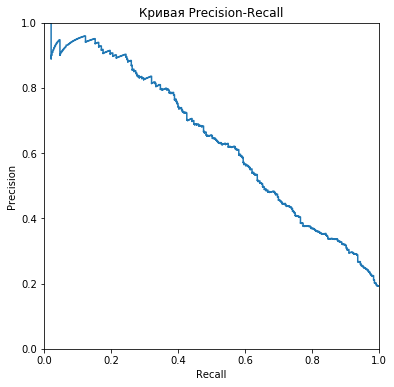

In [35]:
probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Кривая PR показывает, как меняются метрики precision и recall при изменении порога классификации. Мы видим достаточно высокие значения по обозначенным метрикам, что может свидетельствовать о хорошем качестве модели.

**ROC-кривая**

0.8391423001949319


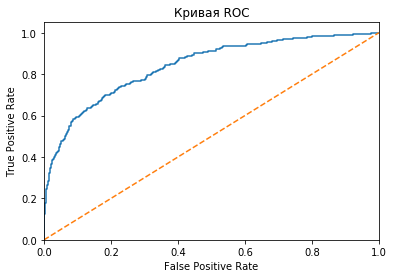

In [36]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()

plt.plot(fpr, tpr) # < постройте график >

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0.0, 1)
plt.ylim([0.0, 1.0])
# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >

plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
plt.title('Кривая ROC')
print(auc_roc)

Кривая показывает, как сильно наша модель отличается от случайной. Значение метрики auc_roc = 0.839142 свидетельствует о достаточно хорошем качестве поолученной модели.

**Диаграмма важности факторов**

Проранжируем важность признаков в порядке убывания. 

Feature ranking:
1. feature 1 (0.289824)
2. feature 4 (0.177986)
3. feature 3 (0.129340)
4. feature 7 (0.104156)
5. feature 0 (0.100310)
6. feature 2 (0.057212)
7. feature 6 (0.050786)
8. feature 8 (0.043146)
9. feature 10 (0.020062)
10. feature 5 (0.013899)
11. feature 9 (0.013279)


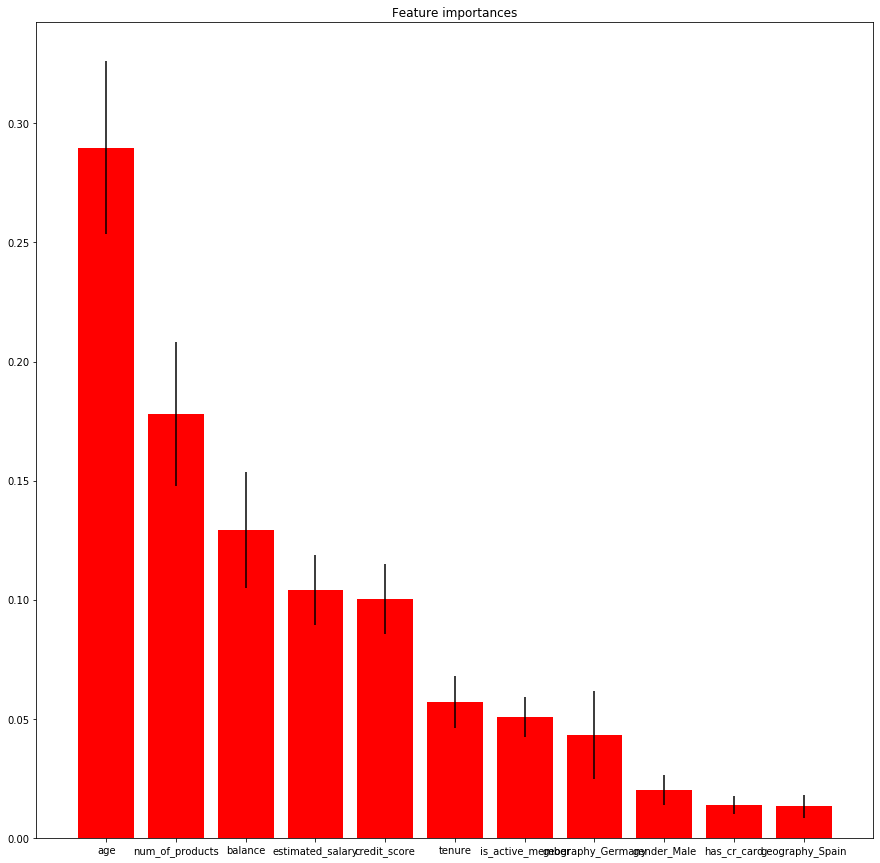

In [37]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_names = features_train.columns
feature_names = [feature_names[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")

for f in range(features_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(features_train.shape[1]), feature_names)
plt.xlim([-1, features_train.shape[1]])
plt.show()

Наиболее значимыми признаками, влияющими на возможность ухода клиента из банка, являются:
- возраст клиента;
- количество продуктов банка, используемых клиентом;
- баланс на счете;
- предполагаемая зарплата;
- кредитный рейтинг.  

В свою очередь, наименее значитыми являются признаки различия пола, страны проживания и наличия кредитной карты.

**Вывод:**  

Мы выявили вид моделей и их гиперпараметры, при которых выполняется требуемое условие по метрике f1>0.59, проанализировали для них значение метрики auc-roc, что позволило нам определить оптимальную модель, а также отразили наиболее значимые признаки, на основании которых можно наиболее достоверно предсказать уход клиента из банка.

## Заключение и общие выводы по проекту

В ходе проведенного исследования мы определили оптимальную модель, которая поможет спрогнозировать уход клиента из банка. 
Полученная модель - модель случайного леса (при `random_state = 42`) с гиперпараметрами:  
- `max_depth = 11`
- `n-estimators = 44`
- `class_weight = "balanced"`

При данных параметрах, метрики будут следующими:

In [38]:
df_metrics.loc['rf_n1']

,type,accuracy,recall,precision,f1,auc-roc
rf_n1,valid,0.85,0.578947,0.611111,0.594595,0.839142
rf_n1,test,0.8475,0.595349,0.661499,0.626683,0.860259
rf_n1,test2,0.851,0.623256,0.663366,0.642686,0.863868


По значимости, в ТОП-3 входят следующие параметры:
- возраст клиента;
- количество продуктов банка, используемых клиентом;
- баланс на счете.